In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 2018-09-13 Getting started with PyNN
# 1/ Neuron examples



In [2]:
import pyNN
pyNN

<module 'pyNN' from '/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/__init__.py'>

In [3]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution, NumpyRNG

#to get a list of models from a certain library :
sim.list_standard_models()

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


['IF_curr_alpha',
 'IF_curr_exp',
 'IF_cond_alpha',
 'IF_cond_exp',
 'IF_cond_exp_gsfa_grr',
 'IF_facets_hardware1',
 'HH_cond_exp',
 'EIF_cond_alpha_isfa_ista',
 'SpikeSourcePoisson',
 'SpikeSourcePoissonRefractory',
 'SpikeSourceGamma',
 'SpikeSourceArray',
 'EIF_cond_exp_isfa_ista',
 'Izhikevich',
 'GIF_cond_exp']

In [4]:
#With PyNN, the model is defined by CellType classes, whose models work on any simulator
refraction_time = RandomDistribution('uniform', [2.0, 3.0], rng = NumpyRNG(seed = 1234))
cortical_params = {'cm':0.25, 'tau_m':20.0, 'v_rest':-60, 'v_thresh':-50, 'tau_refrac':refraction_time, 
                   'v_reset':-60,
                  'v_spike':-50.0, 'a':1.0, 'b':0.005, 'tau_w':600, 'delta_T':2.5, 'tau_syn_E':5.0, 'e_rev_E':0.0,
                  'tau_syn_I':10.0, 'e_rev_I':-80}
thalamocort_params = cortical_params.copy()
thalamocort_params.update({'a':20, 'b': 0.0})

#both cell share the same Ephy properties except for their a and b constants
cortical_cell = sim.EIF_cond_exp_isfa_ista(**cortical_params)
thalamocort_cell = sim.EIF_cond_exp_isfa_ista(**thalamocort_params)

print("Default EIF params : \n %s"% sim.EIF_cond_exp_isfa_ista.default_parameters)
print("Custom TC cell params : \n %s"% thalamocort_params)

Default EIF params : 
 {'cm': 0.281, 'tau_refrac': 0.1, 'v_spike': -40.0, 'v_reset': -70.6, 'v_rest': -70.6, 'tau_m': 9.3667, 'i_offset': 0.0, 'a': 4.0, 'b': 0.0805, 'delta_T': 2.0, 'tau_w': 144.0, 'v_thresh': -50.4, 'e_rev_E': 0.0, 'tau_syn_E': 5.0, 'e_rev_I': -80.0, 'tau_syn_I': 5.0}
Custom TC cell params : 
 {'cm': 0.25, 'tau_m': 20.0, 'v_rest': -60, 'v_thresh': -50, 'tau_refrac': <pyNN.random.RandomDistribution object at 0x7f6b7f6714e0>, 'v_reset': -60, 'v_spike': -50.0, 'a': 20, 'b': 0.0, 'tau_w': 600, 'delta_T': 2.5, 'tau_syn_E': 5.0, 'e_rev_E': 0.0, 'tau_syn_I': 10.0, 'e_rev_I': -80}


In [5]:
#now we can create pops based on the templates
tc_cells = sim.Population(100, thalamocort_cell)
ctx_cells = sim.Population(800, cortical_cell, label = 'A label for retrieval')

#alternatively we can specify a topology and override initial values
from pyNN.space import Grid2D, RandomStructure, Sphere
tc_cells_sphere = sim.Population(100, thalamocort_cell,
                                structure = RandomStructure(boundary=Sphere(radius = 100.)),
                                initial_values = {'v': 70.},
                                label = 'Thalamocortical neurons in a sphere')

v_init = RandomDistribution('uniform', (-70., -55.)) #overriding with generators
ctx_cells_grid = sim.Population(800, thalamocort_cell,
                                structure = Grid2D(dx=10.0, dy=10.0),
                                initial_values = {'v': v_init},
                                label = 'Cortical neurons in a grid')

In [6]:
#pop which can be selected based on ID as in other simulation language
one_cell = ctx_cells[169]
spheric_cells = tc_cells_sphere[:30]
random_cells = ctx_cells_grid.sample(50, rng = NumpyRNG(seed = 4912))

#what gets return is a population view for multi neuron selection
print('Population is from %s'%spheric_cells.parent.label)
print('Random cells IDs are %s'%random_cells.mask)

#assembly is an aggregate of population and populationview, which represents heterogeneous collection of nodes
all_cells = ctx_cells+random_cells
print(all_cells.get_population('A label for retrieval'))

#it is also possible to get params from cells directly
spheric_cells.get('v_reset')

Population is from Thalamocortical neurons in a sphere
Random cells IDs are [780 201 229 728  13 613 490 253 788 762  87 111 502 286 628 406  33 307
  45 751 694 696 134 512 116 593 682 347 378 415  29 135 748  44 577 616
  14 252 177 288 125 165 217 323 166 749 712 525 687 557]
Population(800, EIF_cond_exp_isfa_ista(<parameters>), structure=Line(dx=1.0, x0=0.0, y=0.0, z=0.0), label='A label for retrieval')


-60.0

In [7]:
import numpy as np
#current injections
pulse = sim.DCSource(amplitude = .5, start = 20., stop = 80.)
pulse.inject_into(tc_cells)

times = np.arange(0., 100., 1.)
amps = .1*np.sin(times*np.pi/100)
sine_wave = sim.StepCurrentSource(times = times, amplitudes = amps)
ctx_cells[42:420].inject(sine_wave)

In [8]:
#list of recordable vars
print(ctx_cells.celltype.recordable)

['spikes', 'v', 'w', 'gsyn_exc', 'gsyn_inh']


# 2/ Simulation example

In [9]:
import pyNN.nest as sim
import numpy as np
from pyNN.random import RandomDistribution, NumpyRNG

sim.setup(timestep = .1)

#With PyNN, the model is defined by CellType classes, whose models work on any simulator
refraction_time = RandomDistribution('uniform', [2.0, 3.0], rng = NumpyRNG(seed = 1234))
cortical_params = {'cm':0.25, 'tau_m':20.0, 'v_rest':-60, 'v_thresh':-50, 'tau_refrac':refraction_time, 
                   'v_reset':-60,
                  'v_spike':-50.0, 'a':1.0, 'b':0.005, 'tau_w':600, 'delta_T':2.5, 'tau_syn_E':5.0, 'e_rev_E':0.0,
                  'tau_syn_I':10.0, 'e_rev_I':-80}
thalamocort_params = cortical_params.copy()
thalamocort_params.update({'a':20, 'b': 0.0})

#both cell share the same Ephy properties except for their a and b constants
cortical_cell = sim.EIF_cond_exp_isfa_ista(**cortical_params)
thalamocort_cell = sim.EIF_cond_exp_isfa_ista(**thalamocort_params)

#now we can create pops based on the templates
tc_cells = sim.Population(100, thalamocort_cell)
ctx_cells = sim.Population(800, cortical_cell, label = 'A label for retrieval')

#current injections
pulse = sim.DCSource(amplitude = .5, start = 20., stop = 80.)
pulse.inject_into(tc_cells)

times = np.arange(0., 100., 1.)
amps = .8*np.sin(times*np.pi/100)
sine_wave = sim.StepCurrentSource(times = times, amplitudes = amps)
sine_wave.inject_into(ctx_cells)

ctx_cells.record('spikes')
tc_cells.record('v')
#ctx_cells.sample(10).record('w')

sim.run(200) #ms
sim.end()


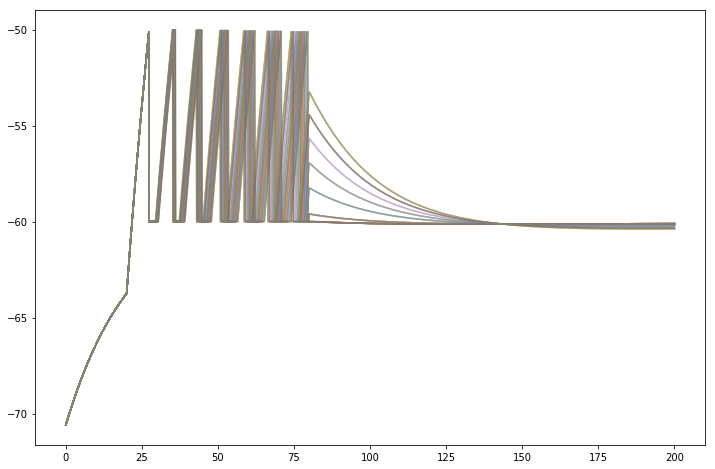

In [10]:
#plotting the hard way with MPL
import matplotlib.pyplot as plt

def plot_spiketrains(spikes):
    for spiketrain in spikes.spiketrains:
        y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
        plt.plot(spiketrain, y)
        plt.ylabel(spikes.name)
        
#ctx_spikes = ctx_cells.get_data()
tc_voltage = tc_cells.get_data()

plt.figure(figsize = (12,8))
for segment in tc_voltage.segments:
    vm = segment.analogsignals[0]
    plt.plot(vm.times, vm, alpha=.15)
#plot_spiketrains(ctx_spikes.segments[0])


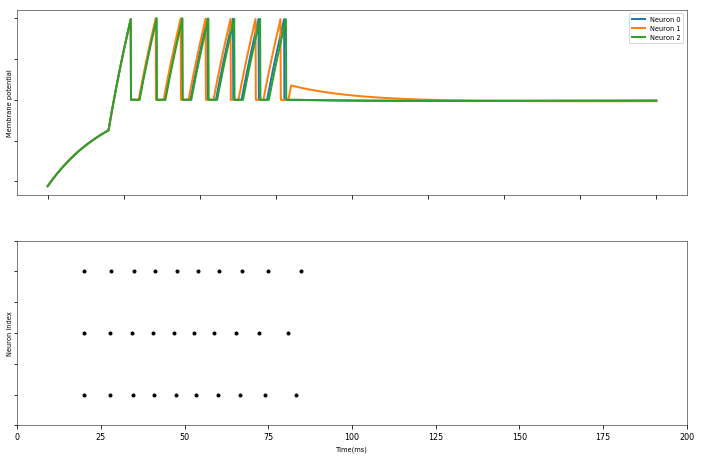

In [11]:
#plotting the short way with PyNN multi panel lib
from pyNN.utility.plotting import Figure, Panel

#post recording segmenting is possible
data = ctx_cells[1:4].get_data().segments[0]
data_voltage = tc_cells[1:4].get_data().segments[0]
voltage = data_voltage.filter(name = 'v')[0]

plt.figure(figsize = (12,8))
Figure(Panel(voltage, ylabel = 'Membrane potential', lw = 2),
      Panel(data.spiketrains, xlabel = 'Time(ms)', xticks = True, lw = 2))

In [12]:
#step by step simulation
import pyNN.nest as sim
import numpy as np
from pyNN.random import RandomDistribution, NumpyRNG

#iterative func should have time as an arg and return next time to call
def report_time(t):
    print('Current time %s' % t)
    return t + 50.

sim.setup(timestep = .1)

#With PyNN, the model is defined by CellType classes, whose models work on any simulator
refraction_time = RandomDistribution('uniform', [2.0, 3.0], rng = NumpyRNG(seed = 1234))
cortical_params = {'cm':0.25, 'tau_m':20.0, 'v_rest':-60, 'v_thresh':-50, 'tau_refrac':refraction_time, 
                   'v_reset':-60,
                  'v_spike':-50.0, 'a':1.0, 'b':0.005, 'tau_w':600, 'delta_T':2.5, 'tau_syn_E':5.0, 'e_rev_E':0.0,
                  'tau_syn_I':10.0, 'e_rev_I':-80}
thalamocort_params = cortical_params.copy()
thalamocort_params.update({'a':20, 'b': 0.5})

#both cell share the same Ephy properties except for their a and b constants
cortical_cell = sim.EIF_cond_exp_isfa_ista(**cortical_params)
thalamocort_cell = sim.EIF_cond_exp_isfa_ista(**thalamocort_params)

#now we can create pops based on the templates
tc_cells = sim.Population(100, thalamocort_cell)
ctx_cells = sim.Population(800, cortical_cell, label = 'A label for retrieval')

#current injections
pulse = sim.DCSource(amplitude = .5, start = 20., stop = 80.)
pulse.inject_into(tc_cells)

times = np.arange(0., 100., 1.)
amps = .8*np.sin(times*np.pi/100)
sine_wave = sim.StepCurrentSource(times = times, amplitudes = amps)
sine_wave.inject_into(ctx_cells)

ctx_cells.record('spikes')
tc_cells.record('v')
#ctx_cells.sample(10).record('w')

sim.run_until(200, callbacks = [report_time]) #ms

Current time 0.0
Current time 50.0
Current time 100.00000000000001
Current time 150.0
Current time 200.0


200.0

# 3/ Synapses

In [13]:
from pyNN.random import RandomDistribution, NumpyRNG
import pyNN.nest as sim
import numpy as np
import time

sim.setup(timestep = .1)

#With PyNN, the model is defined by CellType classes, whose models work on any simulator
refraction_time = RandomDistribution('uniform', [2.0, 3.0], rng = NumpyRNG(seed = 1234))
cortical_params = {'cm':0.25, 'tau_m':20.0, 'v_rest':-60, 'v_thresh':-50, 'tau_refrac':refraction_time, 
                   'v_reset':-60,
                  'v_spike':-50.0, 'a':10.0, 'b':0.00, 'tau_w':600, 'delta_T':2.5, 'tau_syn_E':5.0, 'e_rev_E':0.0,
                  'tau_syn_I':10.0, 'e_rev_I':-80}

thalamocort_params = cortical_params.copy()
thalamocort_params.update({'a':20, 'b': 0.0})

weight_distrib = RandomDistribution('uniform', [.1, 2.], rng = NumpyRNG(seed = 1234))
synapse_params = {'weight' : weight_distrib, 'delay' : '2.+.1*d'} #delay as a func of distance

#both cell share the same Ephy properties except for their a and b constants
cortical_cell = sim.EIF_cond_exp_isfa_ista(**cortical_params)
thalamocort_cell = sim.EIF_cond_exp_isfa_ista(**thalamocort_params)

#Synapses type
del_synapses = sim.StaticSynapse(**synapse_params)
#unused here but a neat example of STDP synapses
stdp_synapses = sim.STDPMechanism(
          weight=0.02,  #initial weight
          delay="0.2 + 0.01*d",
          timing_dependence=sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                          A_plus=0.01, A_minus=0.012),
          weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=0.04))

#now we can create pops based on the templates
tc_cells = sim.Population(100, thalamocort_cell)
ctx_cells = sim.Population(800, cortical_cell, label = 'A label for retrieval')

#connectivity using the projection method
sparse_connectivity = sim.FixedProbabilityConnector(0.1, rng=NumpyRNG(seed = 1234))
inhibitory_connections = sim.Projection(tc_cells,ctx_cells,
                                    connector=sparse_connectivity,
                                    synapse_type=del_synapses,
                                    receptor_type='excitatory',
                                    label="excitatory connections")

#current injections
pulse = sim.DCSource(amplitude = .5, start = 20., stop = 80.)
pulse.inject_into(tc_cells)

ctx_cells.record('v','spikes')
tc_cells.record('v', 'spikes')

sim.run(200) #ms

200.0

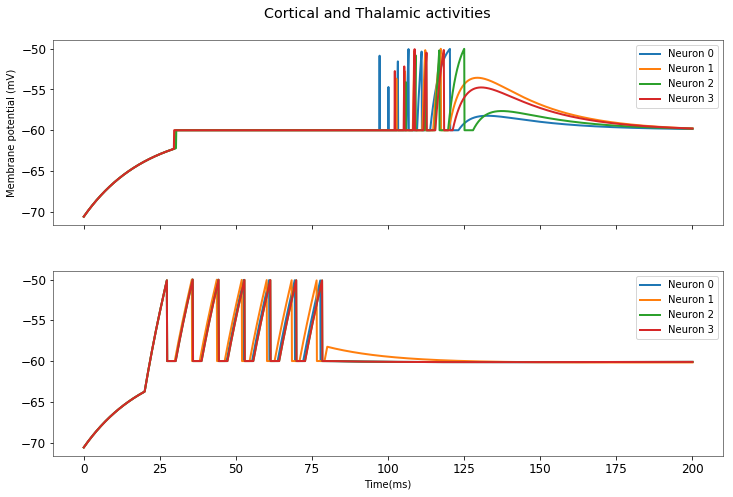

In [14]:
#plotting the short way with PyNN multi panel lib
from pyNN.utility.plotting import Figure, Panel

#post recording segmenting is possible
data_ctx = ctx_cells[1:5].get_data().segments[0]
data_tc = tc_cells[1:5].get_data().segments[0]

voltage = data_voltage.filter(name = 'v')[0]

plt.figure(figsize = (12,8))
Figure(Panel(data_ctx.filter(name = 'v')[0], ylabel = 'Membrane potential (mV)', yticks = True, lw = 2),
      Panel(data_tc.filter(name = 'v')[0], xlabel = 'Time(ms)', xticks = True, yticks = True, lw = 2),
      title = 'Cortical and Thalamic activities', settings = {'font.size' : 12})